# NN Starter - CV 0.0608 - Wow!
Hi everyone. Here is a simple NN MLP starter for Kaggle's May playground competition predicting Calorie expenditure. Using simple architecture and no feature engineering it achieves CV score 0.0608 wow!

# Load Data
We load train, test, and original datasets.

In [1]:
import pandas as pd, numpy as np
VER=1

# LOAD DATA
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
orig = pd.read_csv("/kaggle/input/calories-burnt-prediction/calories.csv")
orig = orig.rename({"Gender":"Sex"},axis=1)
orig = orig.rename({"User_ID":"id"},axis=1)
orig['id'] = np.arange( len(orig) ) + 1_000_000

# DISPLAY DATA
print("Train shape, test shape, original shape:")
print(train.shape, test.shape, orig.shape)
train.head()

Train shape, test shape, original shape:
(750000, 9) (250000, 8) (15000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


# Feature Engineer
We use no feature engineering besides label encoding column Sex.

In [2]:
for df in [train,test, orig]:
    df['Sex'] = df['Sex'].map({'male':0,'female':1}).astype('float32')

In [3]:
FEATURES = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
TARGET = 'Calories'

# Build NN Model
We build a simple TensorFlow MLP with 3 hidden layers, batch normalization, and activation Swish.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
import tensorflow.keras.backend as K

print('TF Version',tf.__version__)

2025-05-06 10:27:18.865685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746527239.030438      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746527239.079412      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version 2.18.0


In [5]:
# SIMPLE MLP
def build_model(size=len(FEATURES)):
    x_in = Input(shape=(size,))
    x = Dense(32)(x_in)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Dense(1, activation='linear')(x)
    model = Model(inputs=x_in, outputs=x)
    return model

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

def make_callbacks():
    lr_callback = ReduceLROnPlateau(
        monitor='val_loss',     
        factor=0.5,              
        patience=3,              
        verbose=1,               
        min_lr=1e-6              
    )
    early_stop_cb = EarlyStopping(
        monitor="val_loss", 
        patience=10,            
        restore_best_weights=True,
        mode="min", 
        verbose=1
    )
    return [lr_callback, early_stop_cb]

EPOCHS = 100

# Train NN Model
We train 5 KFold with early stopping and reduce on plateau learning rate. We train on `log1p` transformed target using RMSE loss. This optimizes the competition metric of RMSLE.

In [7]:
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    
    print(f"\n{'#'*28}")
    print(f"{'#'*10} Fold {i+1} {'#'*10}")
    print(f"{'#'*28}")

    # TRAIN
    X_train = train.loc[train_idx,FEATURES].copy()
    y_train = np.log1p( train.loc[train_idx,TARGET] )

    # EXTRA DATA
    for k in range(4):
        X_train = pd.concat([X_train,orig[FEATURES]],axis=0)
        y_train = pd.concat([y_train,np.log1p( orig[TARGET] )],axis=0)

    # VALID
    X_valid = train.loc[valid_idx,FEATURES].copy()
    y_valid = np.log1p( train.loc[valid_idx,TARGET] )

    # TEST
    X_test = test[FEATURES].copy()

    # NORMALIZE FOR NN
    print("Normalizing...", end='')
    norm_cols = [c for c in FEATURES if c not in []]
    means = X_train[norm_cols].mean()
    stds = X_train[norm_cols].std()
    stds = stds.replace(0, 1)
    X_train[norm_cols] = (X_train[norm_cols] - means) / stds
    X_valid[norm_cols] = (X_valid[norm_cols] - means) / stds
    X_test[norm_cols] = (X_test[norm_cols] - means) / stds
    print("done")
    
    start = time.time()

    K.clear_session()
    model = build_model( X_train.shape[1] )
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                    loss="mse", 
                    metrics=[tf.keras.metrics.RootMeanSquaredError()],
                 )
    model.fit(X_train, y_train, 
              validation_data = (X_valid, y_valid),
              callbacks = make_callbacks(),
              batch_size=256, epochs=EPOCHS, verbose=2)

    oof[valid_idx] = model.predict(X_valid,batch_size=512,verbose=2).flatten()
    pred += model.predict(X_test,batch_size=512,verbose=2).flatten()

    rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
    print(f"Fold {i+1} RMSE: {rmse:.4f}")
    print(f"Feature engineering & training time: {time.time() - start:.1f} sec")

pred /= FOLDS


############################
########## Fold 1 ##########
############################
Normalizing...done


I0000 00:00:1746527252.207329      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746527252.207979      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1746527256.426072      63 service.cc:148] XLA service 0x7bba1c510f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746527256.426530      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746527256.426548      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746527256.762658      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746527258.229957      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2579/2579 - 11s - 4ms/step - loss: 0.6618 - root_mean_squared_error: 0.8135 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - learning_rate: 0.0010
Epoch 2/100
2579/2579 - 4s - 2ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790 - learning_rate: 0.0010
Epoch 3/100
2579/2579 - 4s - 2ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779 - learning_rate: 0.0010
Epoch 4/100
2579/2579 - 4s - 2ms/step - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726 - learning_rate: 0.0010
Epoch 5/100
2579/2579 - 4s - 2ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0667 - learning_rate: 0.0010
Epoch 6/100
2579/2579 - 4s - 2ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650 - learning_rate: 0.0010
Epo

# Compute CV Score
Our simple MLP achieves CV score of 0.0608 wow!

In [8]:
full_rmse = np.sqrt(mean_squared_error(np.log1p(train[TARGET]), oof))
print(f"Overall CV RMSE: {full_rmse:.5f}")
np.save(f"oof_v{VER}",oof)

Overall CV RMSE: 0.06088


# Submission CSV

In [9]:
mn = train.Calories.min()
mx = train.Calories.max()
test['Calories'] = np.clip( np.expm1( pred ),mn,mx )
test[['id','Calories']].to_csv(f"submission_v{VER}.csv",index=False)
test[['id','Calories']].head()

,id,Calories
0,750000,27.515894
1,750001,107.435850
2,750002,86.347258
3,750003,124.953489
4,750004,76.186332


# EDA Test Preds

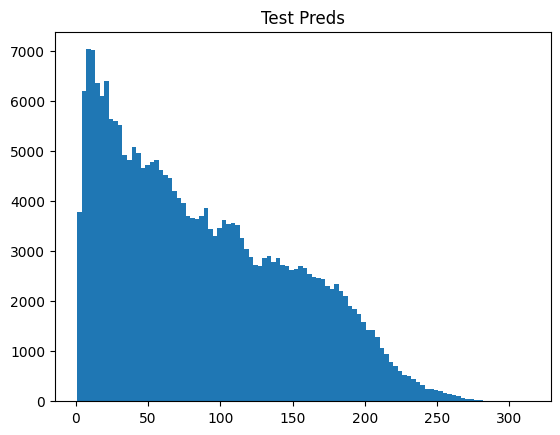

In [10]:
import matplotlib.pyplot as plt

plt.hist(test['Calories'],bins=100)
plt.title("Test Preds")
plt.show()